In [43]:
import torch
import os
import numpy as np

In [2]:
outputs_path = "/mnt/scratch/kf237/experiments/textCNN_first_tries/outputs_trained_subclasses.pt"
print(os.path.exists(outputs_path))
trained_on = "subclasses"

True


In [3]:
outputs_path = "/mnt/scratch/kf237/experiments/textCNN_first_tries/outputs_trained_superclasses.pt"
print(os.path.exists(outputs_path))
trained_on = "superclasses"

True


In [30]:
outputs_path = "outputs_no_shapeshift.pt"
print(os.path.exists(outputs_path))
trained_on = "superclasses"

True


In [31]:
### CNN

outputs = torch.load(outputs_path)


##### alternative for the uncatted data...

In [44]:
selected_lr = "e4"

In [47]:
train_path = "secondExp/"+selected_lr + "_train_outputs.pt"
val_path = "secondExp/"+selected_lr + "_val_outputs.pt"
test_path = "secondExp/"+selected_lr + "_test_outputs.pt"

for path in [train_path, val_path, test_path]:
    if not os.path.exists(path):
        print("No such file: ", path)
    


train_outputs = torch.load(train_path)
val_outputs = torch.load(val_path)
test_outputs = torch.load(test_path)


In [16]:
split_outputs = test_outputs

In [40]:
trained_on = "superclasses"

### cat the data

In [20]:
import tqdm

In [21]:
for key, value in tqdm.tqdm(split_outputs["activations"].items(), desc="concatting activations batches"):
                split_outputs["activations"][key] = torch.cat(value, dim=0)

split_outputs["labels"] = torch.cat(split_outputs["labels"], dim=0)
split_outputs["predictions"] = torch.cat(split_outputs["predictions"], dim=0)
split_outputs["subclasses"] = torch.cat(split_outputs["subclasses"], dim=0)
split_outputs["superclasses"] = torch.cat(split_outputs["superclasses"], dim=0)


concatting activations batches: 100%|██████████| 3/3 [00:00<00:00,  9.88it/s]


### continue

In [22]:
print(split_outputs.keys())
split_activations = split_outputs["activations"]
split_labels = split_outputs["labels"]
split_predictions = split_outputs["predictions"]
split_subclasses = split_outputs["subclasses"]
split_superclasses = split_outputs["superclasses"]

dict_keys(['loss', 'accuracy', 'activations', 'labels', 'subclasses', 'superclasses', 'predictions'])


In [29]:
activations = split_activations
labels = split_labels
predictions = split_predictions
subclasses = split_subclasses
superclasses = split_superclasses

In [23]:
print(split_activations.keys())

dict_keys(['convs.0', 'convs.1', 'convs.2'])


##### all relevant from the outputs

In [50]:


last_epoch = list(outputs.keys())[-1]


# epoch_outputs = outputs[last_epoch]

epoch_outputs = outputs[1]

# epoch_outputs = outputs

print(type(epoch_outputs))
print(epoch_outputs.keys())

print(epoch_outputs.keys())

split_outputs = epoch_outputs["train"]
print(type(split_outputs))
print(split_outputs.keys())

superclasses = split_outputs["superclasses"]
subclasses = split_outputs["subclasses"]

split_activations = split_outputs["activations"]

print(split_activations.keys())






### check for consistency...

labels = split_outputs["labels"]
if trained_on == "superclasses":
    assert torch.equal(superclasses, labels), "superclass and labels must be the same!!!"
elif trained_on == "subclasses":
    assert torch.equal(subclasses, labels), "subclass and labels must be the same!!!"
else:
    raise ValueError("trained_on must be either superclasses or subclasses")




<class 'dict'>
dict_keys(['train', 'val'])
dict_keys(['train', 'val'])
<class 'dict'>
dict_keys(['loss', 'accuracy', 'activations', 'labels', 'subclasses', 'superclasses', 'predictions'])
dict_keys(['convs.0', 'convs.1', 'convs.2'])


#### select one conv

In [13]:
selected_split = "test"

In [ ]:
# selcted_conv = "convs.1"

In [ ]:
# selected_activations = split_activations[selected_conv]

# print(selected_activations.shape)



# out=selected_activations
# activs = out.view(out.size(0), -1).detach().cpu()

# print(activs.shape)




torch.Size([42000, 100, 250])
torch.Size([42000, 25000])


####  catted  activations

In [24]:
conved =[conv for conv in split_outputs["activations"].values()]


print(type(conved))

pooled = [conv.max(dim=-1).values for conv in conved]

cat = torch.cat(pooled, dim=-1)

print(cat.shape)

selected_conv = "all_convs_cat"
selected_activations = cat


<class 'list'>
torch.Size([7000, 300])


## Plot class counts

In [ ]:
import numpy as np


unique_subclass, counts_subclass = np.unique(subclasses.numpy(), return_counts=True)

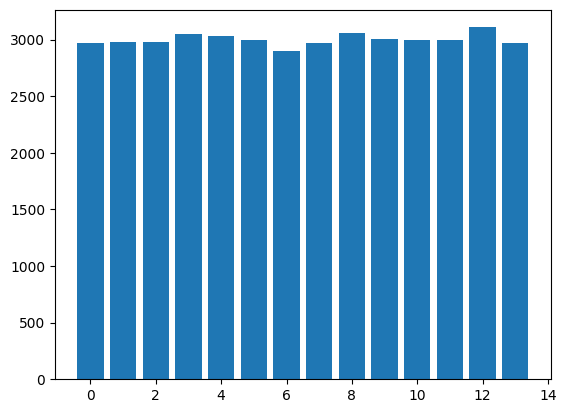

In [27]:
import matplotlib.pyplot as plt



## bar plot

plt.bar(unique_subclass, counts_subclass)
plt.show()

## Train an UMAP reducer

In [26]:
seed = 42

In [27]:
import umap

reducer = umap.UMAP(random_state=seed)

embedding = reducer.fit_transform(selected_activations)


In [30]:

print(embedding.shape)


print(subclasses.shape)

(7000, 2)
torch.Size([7000])


## Plotting the latent space

In [31]:
# Class names
subclass_names = [
    'company', 'educational institution', 'artist', 'athlete', 
    'office holder', 'mean of transportation', 'building', 
    'natural place', 'village', 'animal', 'plant', 
    'album', 'film', 'writtenWork'
]




superclass_names = ["other", "person", "place", "organism", "artwork"]


#### Silhoutte score

In [32]:
from stratification.cluster.fast_sil import silhouette_samples

In [33]:
print(embedding.shape)

(7000, 2)


In [34]:
def get_cluster_sils(SIL_samples, pred_labels, names):
    unique_preds = sorted(np.unique(pred_labels))
    SILs_by_cluster = {
        name: round(float(np.mean(SIL_samples[pred_labels == label])),3)
        for label, name in zip(unique_preds, names)
    }
    return SILs_by_cluster

In [35]:
subclass_sil = silhouette_samples(embedding, subclasses.numpy(), cuda=True)
superclass_sil = silhouette_samples(embedding, superclasses.numpy(), cuda=True)

In [36]:
sil_coef_cluster_subclasses = get_cluster_sils(subclass_sil, subclasses.numpy(), subclass_names)
sil_coef_cluster_superclasses = get_cluster_sils(subclass_sil, superclasses.numpy(), superclass_names)


In [37]:
print(sil_coef_cluster_subclasses)
print(sil_coef_cluster_superclasses)

{'company': 0.217, 'educational institution': 0.475, 'artist': -0.03, 'athlete': 0.188, 'office holder': -0.137, 'mean of transportation': 0.433, 'building': 0.286, 'natural place': 0.339, 'village': -0.217, 'animal': -0.16, 'plant': 0.275, 'album': 0.471, 'film': 0.267, 'writtenWork': 0.253}
{'other': 0.005, 'person': 0.375, 'place': 0.132, 'organism': 0.055, 'artwork': 0.332}


In [38]:
import json

with open("silhouette_scores_superclasses_epoch50.json", "w") as f:
    json.dump({
        "subclasses": sil_coef_cluster_subclasses,
        "superclasses": sil_coef_cluster_superclasses
    }, f)

#### Example sklearn when i want to plot the SIL plots

For n_clusters = 2 The average silhouette_score is : 0.7049787496083262
For n_clusters = 3 The average silhouette_score is : 0.5882004012129721
For n_clusters = 4 The average silhouette_score is : 0.6505186632729437
For n_clusters = 5 The average silhouette_score is : 0.56376469026194
For n_clusters = 6 The average silhouette_score is : 0.4504666294372765


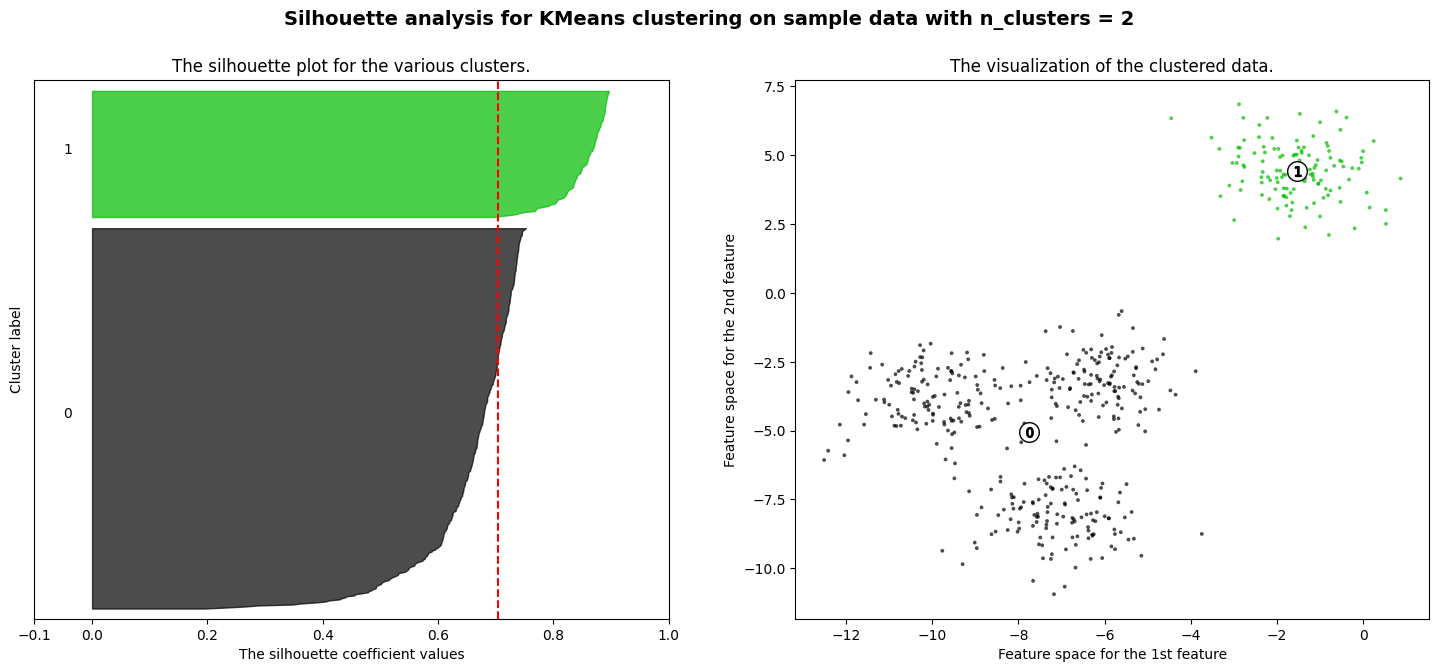

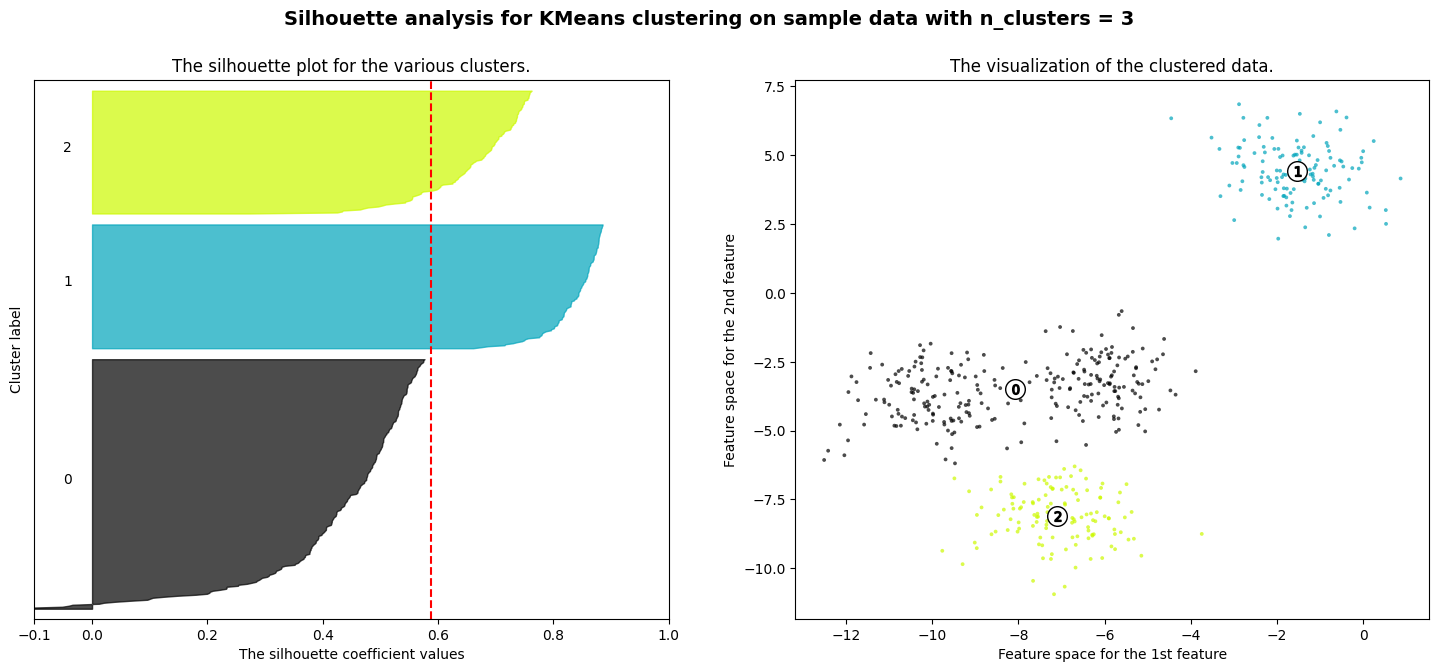

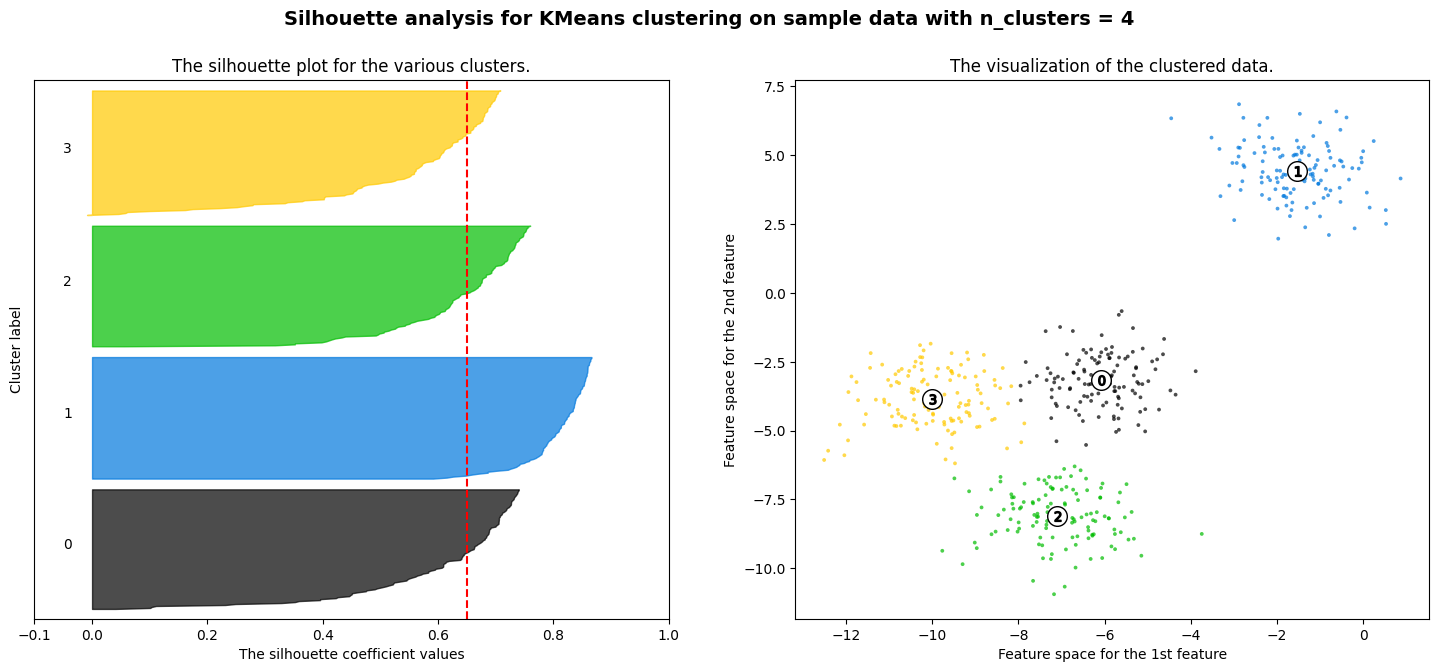

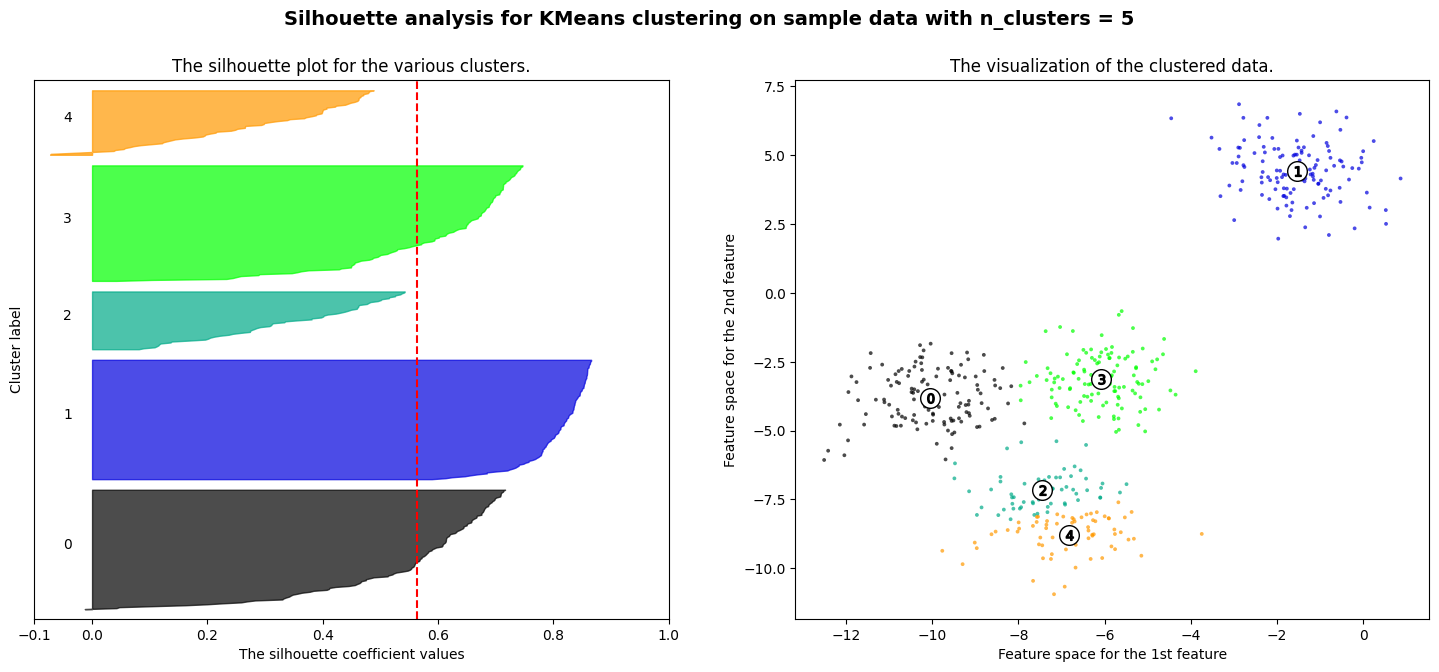

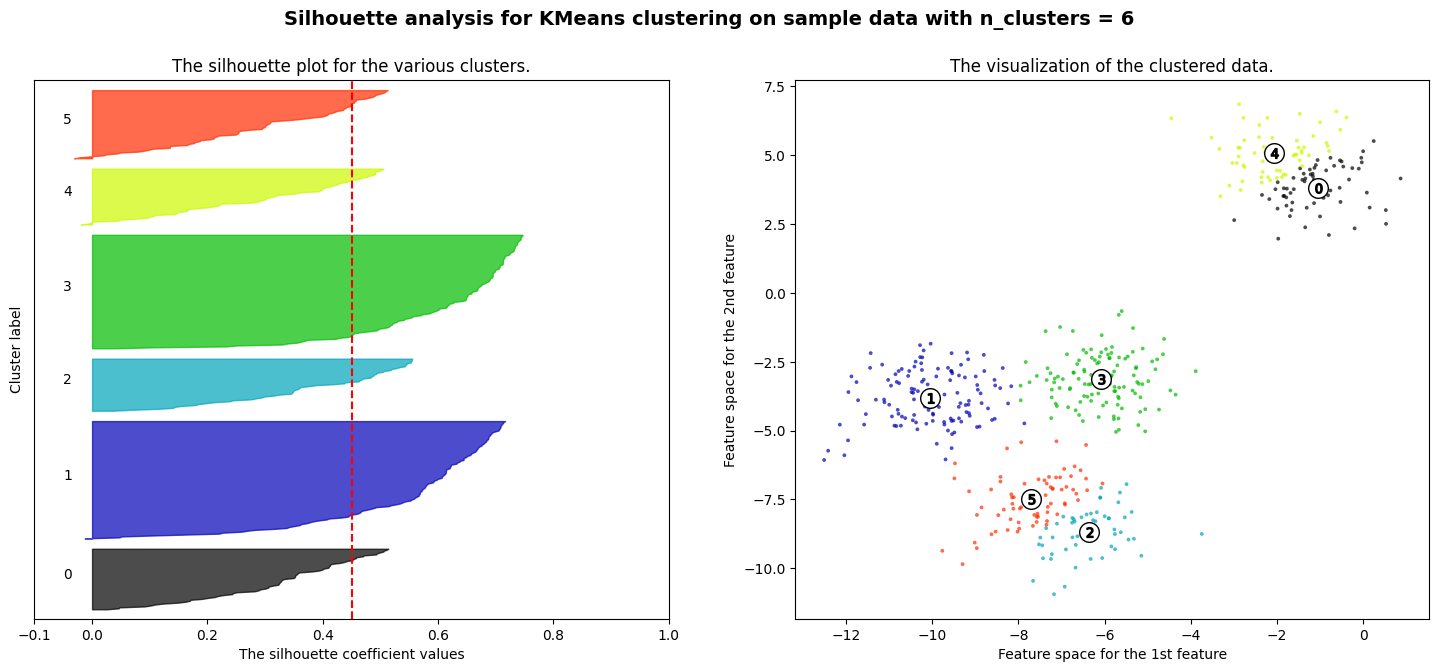

In [43]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(
    n_samples=500,
    n_features=2,
    centers=4,
    cluster_std=1,
    center_box=(-10.0, 10.0),
    shuffle=True,
    random_state=1,
)  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

### The entire latentspace

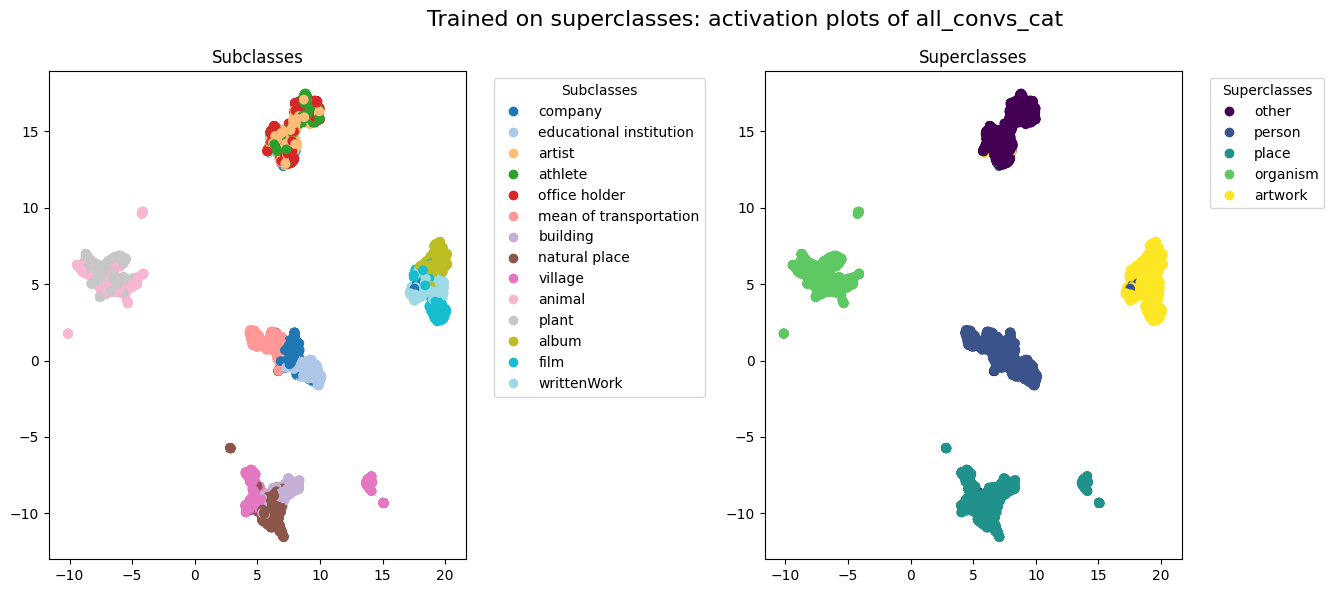

In [41]:
import matplotlib.pyplot as plt
import numpy as np



# Set up the figure and subplots
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))  # Adjust width and height as desired

# Set the overall title for the figure
fig.suptitle(f"Trained on {trained_on}: activation plots of {selected_conv}", fontsize=16)

# First subplot
scatter1 = axes[0].scatter(embedding[:, 0], embedding[:, 1], c=subclasses, cmap="tab20")
legend_elements1, _ = scatter1.legend_elements()
axes[0].legend(legend_elements1, subclass_names, title="Subclasses", bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].set_title("Subclasses")

# Second subplot (same data)
scatter2 = axes[1].scatter(embedding[:, 0], embedding[:, 1], c=superclasses, cmap="viridis")
legend_elements2, _ = scatter2.legend_elements()
axes[1].legend(legend_elements2, superclass_names, title="Superclasses", bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].set_title("Superclasses")

# Adjust layout to make room for legends and title
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust rect to fit legends and title

# Display plot
plt.show()


### only one specific subclass...

In [27]:
#### filter the activations by class


filtered_superclass = 0



## first  construc the binary mask

superclasses_np = np.array(superclasses)

mask = superclasses_np == filtered_superclass

filtered_activations = selected_activations.numpy()[mask]

filtered_subclass_lables = subclasses.numpy()[mask]


unique_labels = np.unique(filtered_subclass_lables)

print(unique_labels)

filtered_subclass_names = [ name for i, name in enumerate(subclass_names) if i in unique_labels]

print(filtered_subclass_names)






[2 3 4]
['artist', 'athlete', 'office holder']


In [ ]:

reducer = umap.UMAP(random_state=seed)
filted_embedding = reducer.fit_transform(filtered_activations)

In [ ]:
import matplotlib.pyplot as plt



# Set the figure size to make the plot wider
plt.figure(figsize=(10, 6))  # Adjust width (12) and height (6) as desired


# Create scatter plot
scatter = plt.scatter(filted_embedding[:, 0], filted_embedding[:, 1], c=filtered_subclass_lables, cmap="viridis")

# Create legend and position it outside the plot to the right
legend_elements, _ = scatter.legend_elements()
plt.legend(legend_elements, filtered_subclass_names, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjusts the plot to leave room for the legend on the right

plt.title(f"activation plot of {selected_conv} for superclass {filtered_superclass}")

# Display plot
plt.show()


### all subclasses

[2 3 4]
['artist', 'athlete', 'office holder']
[0 1 5]
['company', 'educational institution', 'mean of transportation']
[6 7 8]
['building', 'natural place', 'village']
[ 9 10]
['animal', 'plant']
[11 12 13]
['album', 'film', 'writtenWork']


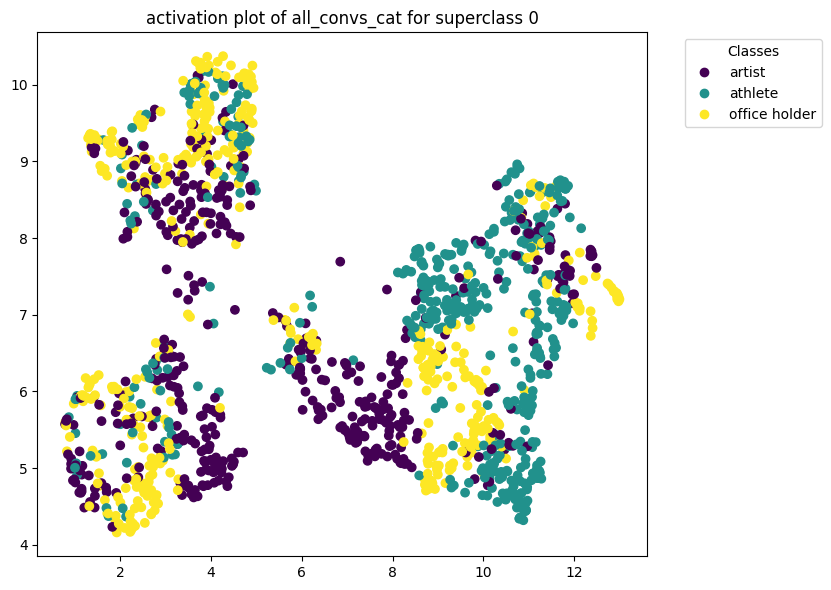

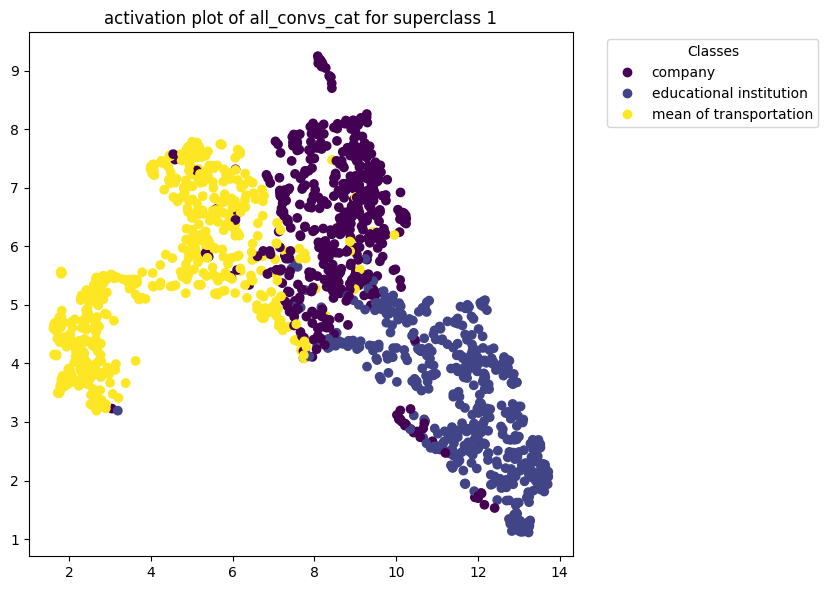

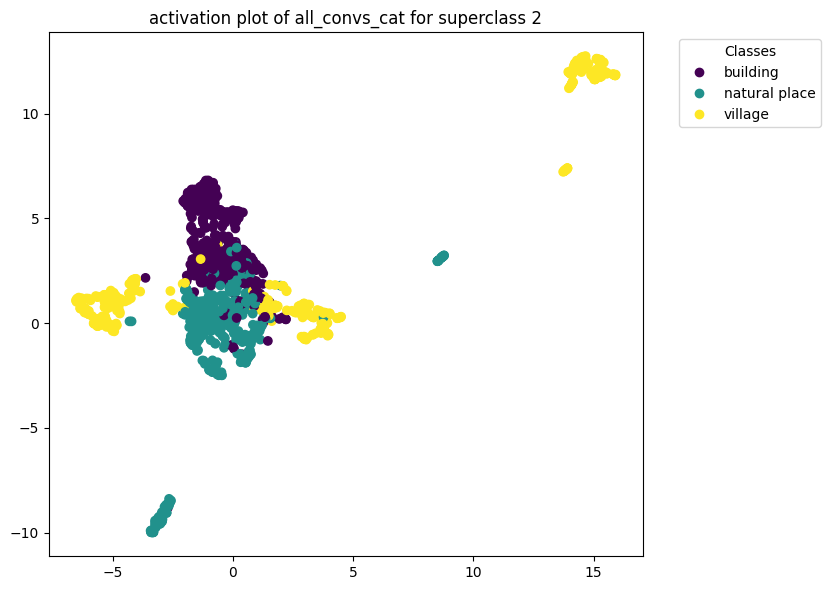

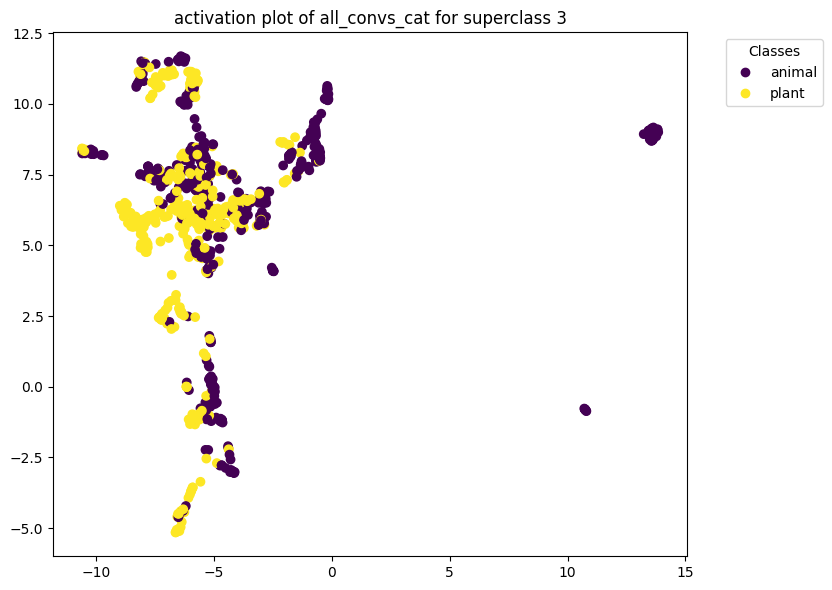

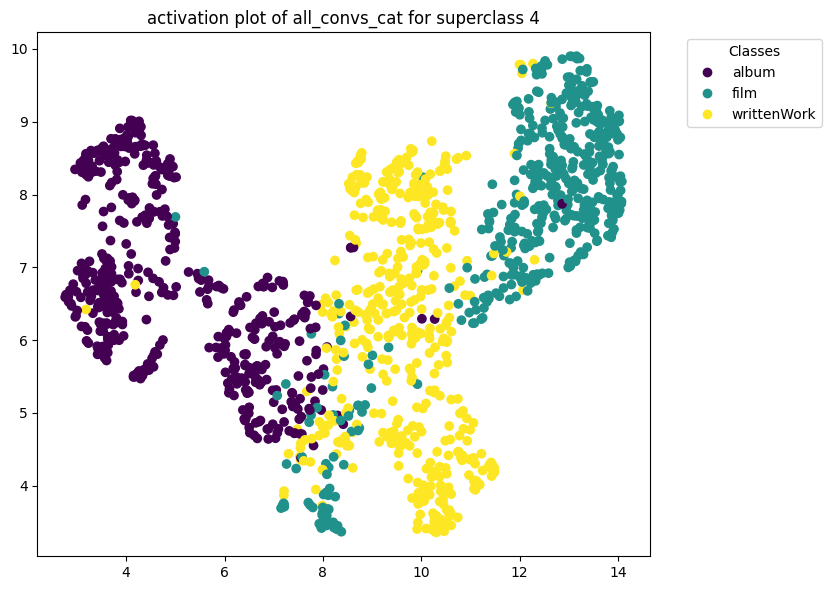

In [42]:
### complete.....
import matplotlib.pyplot as plt


for filtered_superclass in range(5):
 



    ## first  construc the binary mask

    superclasses_np = np.array(superclasses)

    mask = superclasses_np == filtered_superclass

    filtered_activations = selected_activations.numpy()[mask]

    filtered_subclass_lables = subclasses.numpy()[mask]


    unique_labels = np.unique(filtered_subclass_lables)

    print(unique_labels)

    filtered_subclass_names = [ name for i, name in enumerate(subclass_names) if i in unique_labels]

    print(filtered_subclass_names)




    reducer = umap.UMAP(random_state=seed)
    filted_embedding = reducer.fit_transform(filtered_activations)





    # Set the figure size to make the plot wider
    plt.figure(figsize=(10, 6))  # Adjust width (12) and height (6) as desired


    # Create scatter plot
    scatter = plt.scatter(filted_embedding[:, 0], filted_embedding[:, 1], c=filtered_subclass_lables, cmap="viridis")

    # Create legend and position it outside the plot to the right
    legend_elements, _ = scatter.legend_elements()
    plt.legend(legend_elements, filtered_subclass_names, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.title(f"activation plot of {selected_conv} for superclass {filtered_superclass}")

    # Adjust layout to make room for the legend
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjusts the plot to leave room for the legend on the right



    plt.savefig(f"activation_plot_{selected_conv}_superclass_{filtered_superclass}.png")

## Transformer

In [ ]:
path = os.path.join("testRunArticles","collector.pt")
collector = torch.load(path)
epoch_1 = collector[0]
print(epoch_1.keys())

trainSplit = epoch_1["train_outputs"]
activations = trainSplit["activations"]
targets = trainSplit["targets"]
preds = trainSplit["preds"]
true_subclasses = trainSplit["true_subclass"]
print(targets.shape)
print(activations.shape)
print(preds.shape)
print(true_subclasses.shape)

In [ ]:
print(trainSplit.keys())

In [ ]:
print(trainSplit["true_subclass"].shape)
print(trainSplit["targets"].shape)

In [ ]:
print(targets.unique())
print(trainSplit["true_subclass"].unique())

In [ ]:
print(activations.shape)
print(targets.shape)
print(preds.shape)
print(true_subclasses.shape)

In [ ]:
selcted_superclass = 3

In [ ]:
selected_activations = activations[targets == selcted_superclass]
selected_subclasses = true_subclasses[targets == selcted_superclass]

In [ ]:
import umap

reducer = umap.UMAP()

embedding = reducer.fit_transform(selected_activations)


In [ ]:
print(embedding.shape)
print(selected_subclasses.shape)


print(selected_subclasses.unique())

In [ ]:
true_subclass_names = [
        " 0 - Company",
        " 1 - Educational Institution",
        " 2 - Artist",
        " 3 - Athlete",
        " 4 - Office Holder",
        " 5 - Mean of Transportation",
        " 6 - Building",
        " 7 - Natural Place",
        " 8 - Village",
        " 9 - Animal",
        "10 - Plant",
        "11 - Album",
        "12 - Film",
        "13 - Written Work",
    
    ]

In [ ]:
used_subclass_names = [true_subclass_names[i] for i in selected_subclasses.unique()]
print(used_subclass_names)

In [ ]:
import matplotlib.pyplot as plt
scatter = plt.scatter(embedding[:,0], embedding[:,1])
plt.legend()

In [ ]:
### plot the embedding
import matplotlib.pyplot as plt
scatter = plt.scatter(embedding[:, 0], embedding[:, 1],s =1,c = selected_subclasses, cmap='tab20')
legend = plt.legend(handles=scatter.legend_elements()[0], labels=used_subclass_names, title="Classes", loc='upper right', bbox_to_anchor=(1.5, 1))
plt.show()